# ResNet-50 Based Hand Pose Estimation
This is a Hand Pose Estimation model based on the ResNet-50 architecture.
The goal of this model is to predict the x, y, and z coordinate values for 21 landmark points of the left and right hands extracted by mediapipe, respectively, in a given hand image.

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score

## 1. Data Load and Preprocessing

In [60]:
music_folder = 'music'
file_list = os.listdir(music_folder)

# 이미지 파일만 필터링 (확장자가 .jpg 인 파일)
image_files = [f for f in file_list if f.endswith('.jpg')]

# 파일 이름을 정렬하여 순서대로 처리
image_files.sort()

# 숫자를 1부터 시작하여 새로운 이름으로 변경
for i, image_file in enumerate(image_files, start=1):
    old_path = os.path.join(music_folder, image_file)
    
    # 현재 파일 이름에서 "output_music4-" 다음에 오는 숫자를 추출
    match = re.search(r'music4-(\d+)', image_file)
    if match:
        number = int(match.group(1))
        
        # 숫자를 1부터 시작하는 값으로 변경하여 새로운 이름 생성
        new_number = i
        new_file_name = f"{new_number}.jpg"
        
        # 새로운 파일 경로 생성
        new_path = os.path.join(music_folder, new_file_name)
        
        # 파일 이름 변경
        os.rename(old_path, new_path)
        print(f"Renamed {old_path} to {new_path}")

print("File renaming complete.")


File renaming complete.


In [3]:
# Custom Dataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 이미지 파일 이름 설정 (1부터 시작하므로 idx + 1)
        img_name = os.path.join(self.img_dir, str(idx + 1) + ".jpg")
        image = Image.open(img_name)
        
        # 해당 행의 라벨 데이터 (x, y, z 좌표)를 추출
        labels = torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels


# 이미지 전처리를 원하는대로 수정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 및 DataLoader 설정
dataset = CustomDataset(csv_path="hand_result.csv", img_dir="music/", transform=transform)

batch_size=64
# 데이터를 6:2:2 비율로 분할
total_dataset_size = len(dataset)
train_size = int(0.6 * total_dataset_size)
val_size = int(0.2 * total_dataset_size)
test_size = total_dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 분할된 데이터셋의 크기 확인
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 1979
Validation dataset size: 659
Test dataset size: 661


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 1:
Image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([126])
Labels: tensor([ 8.4603e+02,  5.9959e+02,  1.3100e-07,  8.1001e+02,  5.7806e+02,
        -1.0308e-02,  7.9041e+02,  5.4700e+02, -1.6113e-02,  7.7498e+02,
         5.1992e+02, -2.0709e-02,  7.5625e+02,  5.0408e+02, -2.5143e-02,
         8.3546e+02,  5.1335e+02, -8.3133e-03,  8.4318e+02,  4.7964e+02,
        -1.3071e-02,  8.4517e+02,  4.5746e+02, -1.7861e-02,  8.4447e+02,
         4.4034e+02, -2.1715e-02,  8.5984e+02,  5.1659e+02, -8.0247e-03,
         8.7147e+02,  4.8210e+02, -1.1045e-02,  8.7523e+02,  4.5898e+02,
        -1.5266e-02,  8.7673e+02,  4.4096e+02, -1.9072e-02,  8.7815e+02,
         5.2532e+02, -8.8948e-03,  8.9043e+02,  4.9228e+02, -1.3303e-02,
         8.9416e+02,  4.7054e+02, -1.7803e-02,  8.9503e+02,  4.5325e+02,
        -2.1404e-02,  8.9114e+02,  5.3749e+02, -1.0602e-02,  9.0912e+02,
         5.1762e+02, -1.5271e-02,  9.1731e+02,  5.0273e+02, -1.7854e-02,
         9.2285e+02,  4.8970e+02, -

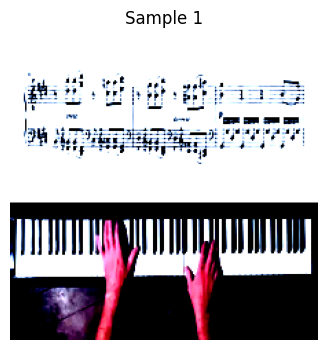

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 2:
Image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([126])
Labels: tensor([ 8.6389e+02,  5.9407e+02,  1.3600e-07,  8.2712e+02,  5.8028e+02,
        -9.9030e-03,  8.0099e+02,  5.5502e+02, -1.6153e-02,  7.8019e+02,
         5.3208e+02, -2.0964e-02,  7.5957e+02,  5.1858e+02, -2.5743e-02,
         8.3654e+02,  5.1928e+02, -1.2850e-02,  8.2693e+02,  4.8426e+02,
        -1.9374e-02,  8.2025e+02,  4.6103e+02, -2.4524e-02,  8.1513e+02,
         4.4299e+02, -2.8397e-02,  8.6192e+02,  5.1487e+02, -1.3079e-02,
         8.6427e+02,  4.7664e+02, -1.7454e-02,  8.6379e+02,  4.5215e+02,
        -2.1790e-02,  8.6320e+02,  4.3257e+02, -2.5483e-02,  8.8228e+02,
         5.1769e+02, -1.4045e-02,  8.8702e+02,  4.8124e+02, -1.9725e-02,
         8.8819e+02,  4.5805e+02, -2.4208e-02,  8.8782e+02,  4.3916e+02,
        -2.7622e-02,  8.9737e+02,  5.2595e+02, -1.5591e-02,  9.1091e+02,
         5.0271e+02, -2.1827e-02,  9.1751e+02,  4.8733e+02, -2.4351e-02,
         9.2244e+02,  4.7441e+02, -

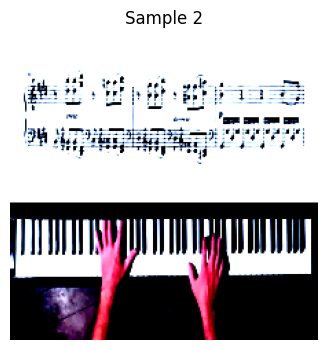

Sample 3:
Image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([126])
Labels: tensor([ 7.5047e+02,  6.3295e+02,  2.4500e-08,  7.0688e+02,  6.2756e+02,
        -2.2988e-03,  6.8247e+02,  6.0153e+02, -3.7887e-03,  6.7008e+02,
         5.7020e+02, -4.5828e-03,  6.6052e+02,  5.4585e+02, -4.7312e-03,
         6.9352e+02,  5.6619e+02, -5.7101e-03,  6.8221e+02,  5.2626e+02,
        -8.6062e-03,  6.7657e+02,  5.0708e+02, -9.1109e-03,  6.7317e+02,
         4.9607e+02, -8.5547e-03,  7.1779e+02,  5.5503e+02, -6.3482e-03,
         7.0789e+02,  5.1028e+02, -7.6486e-03,  6.9957e+02,  4.9210e+02,
        -6.9869e-03,  6.9277e+02,  4.8424e+02, -5.9810e-03,  7.3776e+02,
         5.5096e+02, -7.0334e-03,  7.3036e+02,  5.0939e+02, -8.1808e-03,
         7.2077e+02,  4.9117e+02, -7.6753e-03,  7.1204e+02,  4.8180e+02,
        -7.1463e-03,  7.5273e+02,  5.5263e+02, -7.7487e-03,  7.5324e+02,
         5.2352e+02, -7.7757e-03,  7.4948e+02,  5.0730e+02, -6.1507e-03,
         7.4437e+02,  4.9648e+02, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


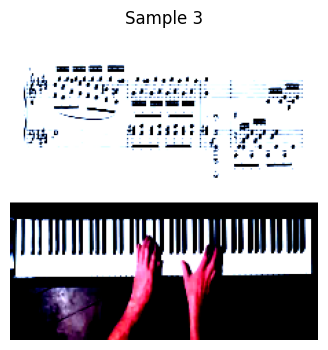

In [4]:
import matplotlib.pyplot as plt

# Load Samples
num_samples_to_display = 3
samples = []
for i in range(num_samples_to_display):
    sample_idx = i  # index
    image, labels = test_dataset[sample_idx]
    samples.append((image, labels))

# Visualization
for i, (image, labels) in enumerate(samples):
    print(f"Sample {i + 1}:")
    print("Image shape:", image.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image.permute(1, 2, 0))  # 이미지 형식 변경 (C, H, W) -> (H, W, C)
    plt.title(f"Sample {i + 1}")
    plt.axis("off")
    plt.show()

## 2. Define Model and Train Model

In [7]:
# 모델 클래스 정의
class HandPoseResNet(nn.Module):
    def __init__(self, num_keypoints_per_hand=21):
        super(HandPoseResNet, self).__init__()
        # ResNet-50
        self.resnet = models.resnet50(pretrained=True)
        
        # 마지막 fully connected layer를 변경하여 출력 크기를 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_keypoints_per_hand * 3 * 2)  # (왼손 + 오른손) * (x, y, z) 좌표 (21개 * 3 * 2)
        )

    def forward(self, x):
        return self.resnet(x)

In [8]:
# CUDA ~ Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
model = HandPoseResNet(num_keypoints_per_hand=21).to(device)

# 손실 함수, 옵티마이저 설정
criterion = nn.L1Loss()  # L1 손실 함수 사용 (절대 오차)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 에포크 수 설정
num_epochs = 100

# 에포크마다의 훈련 정확도와 검증 정확도를 저장할 리스트 초기화
train_accuracy_for_plot = []
val_accuracy_for_plot = []

for epoch in range(num_epochs):
    # 모델을 훈련 모드로 설정
    model.train()
    
    # 에포크마다의 훈련 손실과 검증 손실을 저장할 리스트 초기화
    train_losses = []

    # 훈련 데이터로 모델 훈련
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
    
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 검증 데이터로 모델 평가
    val_losses = []
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
    
    # 에포크마다 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {loss.item():.4f}")
    print(f"Validation Loss: {np.mean(val_losses):.4f}")

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100]
Train Loss: 368.2986
Validation Loss: 344.3870
Epoch [2/100]
Train Loss: 310.4704
Validation Loss: 299.7129
Epoch [3/100]
Train Loss: 241.5932
Validation Loss: 224.9093
Epoch [4/100]
Train Loss: 147.3792
Validation Loss: 124.0617
Epoch [5/100]
Train Loss: 77.7251
Validation Loss: 146.5025
Epoch [6/100]
Train Loss: 68.1083
Validation Loss: 71.3344
Epoch [7/100]
Train Loss: 62.0905
Validation Loss: 65.2330
Epoch [8/100]
Train Loss: 59.9578
Validation Loss: 62.1062
Epoch [9/100]
Train Loss: 59.2747
Validation Loss: 72.8121
Epoch [10/100]
Train Loss: 56.8010
Validation Loss: 63.5716
Epoch [11/100]
Train Loss: 62.9264
Validation Loss: 59.7251
Epoch [12/100]
Train Loss: 61.9827
Validation Loss: 62.9527
Epoch [13/100]
Train Loss: 62.9221
Validation Loss: 59.8972
Epoch [14/100]
Train Loss: 57.4556
Validation Loss: 58.2107
Epoch [15/100]
Train Loss: 56.3045
Validation Loss: 57.1490
Epoch [16/100]
Train Loss: 52.4853
Validation Loss: 63.7284
Epoch [17/100]
Train Loss: 58.7375
Valid

In [66]:
from torchsummary import summary
summary(model, (3, 224, 224))  # 입력 이미지 크기 (3 채널, 224x224 픽셀)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 3. Evaluate Model

In [19]:
from sklearn.metrics import mean_squared_error

# 모델을 평가 모드로 설정
model.eval()

# 데이터 로더 설정 (테스트)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 평균 제곱 오차를 저장할 빈 리스트 생성
test_losses = []

# 예측된 라벨과 실제 라벨을 저장할 리스트 생성
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        test_loss = criterion(outputs, labels)
        test_losses.append(test_loss.item())

        predicted_labels.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 테스트 데이터에 대한 평균 제곱 오차 계산
test_mse = np.mean(test_losses)

# 평균 제곱 오차 출력
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}")

Test Mean Squared Error (MSE): 32.5769


In [20]:
print(f'Test Dataset 갯수: {len(predicted_labels)}')
print(f'예측 레이블 수: {len(predicted_labels[0])}')
print(f'0번째 idx를 가진 testdata에 대한 랜드마크 예측 값 {predicted_labels[0]}')

Test Dataset 갯수: 661
예측 레이블 수: 126
0번째 idx를 가진 testdata에 대한 랜드마크 예측 값 [ 8.2962988e+02  6.0476392e+02  1.6650113e-01  7.9497430e+02
  5.8814270e+02  8.4516615e-02  7.7736499e+02  5.5704480e+02
 -5.3982979e-01  7.6614728e+02  5.2897205e+02 -1.3480294e-01
  7.5034277e+02  5.0996100e+02  5.9741598e-01  8.1813470e+02
  5.2026447e+02  2.5732893e-01  8.2587976e+02  4.8595514e+02
  3.2360633e-03  8.2790692e+02  4.6541907e+02 -3.8765293e-01
  8.2893536e+02  4.5040137e+02 -6.6510357e-02  8.4226959e+02
  5.2070270e+02 -8.2782194e-02  8.5404547e+02  4.8311023e+02
 -2.3459004e-01  8.5764545e+02  4.6071857e+02 -8.2102048e-01
  8.5985028e+02  4.4450186e+02  3.8943893e-01  8.6000189e+02
  5.2747620e+02 -2.6557989e-02  8.7121027e+02  4.9067267e+02
 -3.4949416e-01  8.7524475e+02  4.6991043e+02 -3.1296009e-01
  8.7618347e+02  4.5377457e+02  7.8998059e-02  8.7212646e+02
  5.3588110e+02  2.7929157e-01  8.8730249e+02  5.1140784e+02
  5.9198879e-02  8.9484296e+02  4.9731677e+02 -1.8719040e-01
  9.0080231e+02

## 4. Test Model

In [27]:
# 모델을 평가 모드로 설정
model.eval()

# 예측값을 저장할 빈 리스트 생성
predictions = []

# DataLoader를 사용하여 데이터를 반복하고 예측을 수집
with torch.no_grad():
    for inputs, _ in test_dataloader:  # 여기에서는 라벨을 사용하지 않으므로 "_"로 처리
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())

# 예측을 하나의 NumPy 배열로 변환
predictions = np.concatenate(predictions, axis=0)

# 예측 결과 확인
print("Predictions shape:", predictions.shape)

Predictions shape: (661, 126)


Original Image


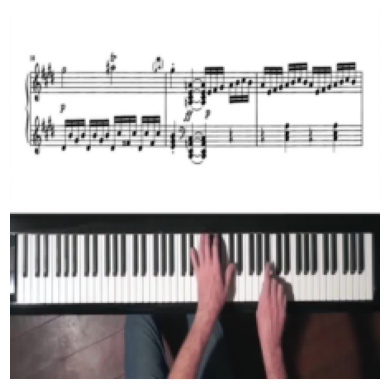

Model Predictions:
[ 5.98896729e+02  5.98715454e+02  2.35044211e-03  5.60786621e+02
  5.91540222e+02  1.53123304e-01  5.39650574e+02  5.64744019e+02
 -3.55323642e-01  5.30459106e+02  5.35227905e+02 -6.48754835e-02
  5.20665955e+02  5.12609619e+02  4.50760305e-01  5.65188477e+02
  5.27046814e+02  1.65606916e-01  5.65037048e+02  4.89732452e+02
 -3.03929523e-02  5.63236328e+02  4.69236084e+02 -1.85546443e-01
  5.62435730e+02  4.56537231e+02 -4.60789092e-02  5.88734619e+02
  5.19462952e+02 -3.71401310e-02  5.89307922e+02  4.78250763e+02
 -2.00865105e-01  5.87320007e+02  4.57658356e+02 -7.25939989e-01
  5.85484741e+02  4.44604309e+02  2.79216588e-01  6.08202881e+02
  5.19330200e+02 -6.87134340e-02  6.08750122e+02  4.78289429e+02
 -2.86986291e-01  6.07770874e+02  4.58845123e+02 -2.33578742e-01
  6.05312622e+02  4.45657501e+02  1.26886636e-01  6.23593994e+02
  5.21122070e+02  2.06676453e-01  6.29233276e+02  4.88902069e+02
  1.73063099e-01  6.31118591e+02  4.72672333e+02 -1.23779431e-01
  6.32

In [55]:
import csv
# 평균과 표준 편차
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# 전처리 역변환 함수
def reverse_normalize(image):
    reverse_normalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1 / std[0], 1 / std[1], 1 / std[2]]),
        transforms.Normalize(mean=[-mean[0], -mean[1], -mean[2]], std=[1, 1, 1])
    ])
    return reverse_normalize(image)

# 예측을 역 정규화하여 원래 값으로 변환
sample_idx = 10  # 확인하고 싶은 test data의 idx
original_image = reverse_normalize(test_dataset[sample_idx][0])  # 입력 이미지 역 정규화
predicted_values = predictions[sample_idx]  # 모델 예측 값

# 원본 이미지와 모델 예측 값을 출력
print(f"Original Image")
plt.imshow(original_image.permute(1, 2, 0))
plt.axis("off")
plt.show()

# 1.csv 파일 경로 설정
csv_file = '1.csv'

# 라벨 값을 1.csv 파일에 한 행에 모두 저장
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(predicted_values)
    writer.writerow([value.item() for value in original_labels])

print("Model Predictions:")
print(predicted_values)

In [50]:
# predict
import csv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

# 1.csv 파일 경로 설정
csv_file = '1.csv'

# 라벨 값을 저장할 리스트 초기화
label_values = []

# 1.csv 파일에서 라벨 값 로드
with open(csv_file, mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        label_values = [float(value) for value in row]
        
label_values

[598.8967,
 598.71545,
 0.002350442,
 560.7866,
 591.5402,
 0.1531233,
 539.6506,
 564.744,
 -0.35532364,
 530.4591,
 535.2279,
 -0.06487548,
 520.66595,
 512.6096,
 0.4507603,
 565.1885,
 527.0468,
 0.16560692,
 565.03705,
 489.73245,
 -0.030392952,
 563.2363,
 469.23608,
 -0.18554644,
 562.4357,
 456.53723,
 -0.04607891,
 588.7346,
 519.46295,
 -0.03714013,
 589.3079,
 478.25076,
 -0.2008651,
 587.32,
 457.65836,
 -0.72594,
 585.48474,
 444.6043,
 0.2792166,
 608.2029,
 519.3302,
 -0.068713434,
 608.7501,
 478.28943,
 -0.2869863,
 607.7709,
 458.84512,
 -0.23357874,
 605.3126,
 445.6575,
 0.12688664,
 623.594,
 521.1221,
 0.20667645,
 629.2333,
 488.90207,
 0.1730631,
 631.1186,
 472.67233,
 -0.12377943,
 632.4168,
 460.9138,
 -0.17886896,
 373.59445,
 668.70184,
 0.02012088,
 404.49484,
 648.98285,
 -0.119289145,
 420.3442,
 615.7972,
 -0.031422205,
 427.9422,
 582.977,
 0.32580462,
 435.20062,
 562.07245,
 -0.09415557,
 383.02322,
 589.89417,
 0.28325054,
 382.9406,
 546.1262,
 0.0

In [51]:
# predict
def coord_division(coord_list):
    x_list = []
    y_list = []
    z_list = []
    
    for i in range(len(coord_list)): # len(coord_list) : 126개
        if i % 3 == 0:
            x_list.append(coord_list[i])
        elif i % 3 == 1:
            y_list.append(coord_list[i])
        else:
            z_list.append(coord_list[i])
    
    # 각 리스트를 NumPy 배열로 변환하여 반환
    x_array = np.array(x_list)
    y_array = np.array(y_list)
    z_array = np.array(z_list)
    
    return x_array, y_array, z_array

# 1.csv 파일에서 로드한 라벨 값을 coord_division 함수에 전달하여 좌표를 나눠서 저장
x_coords, y_coords, z_coords = coord_division(label_values)
#print(x_coords)
#print(x_coords)
#print(x_coords)

MovieWriter ffmpeg unavailable; using Pillow instead.


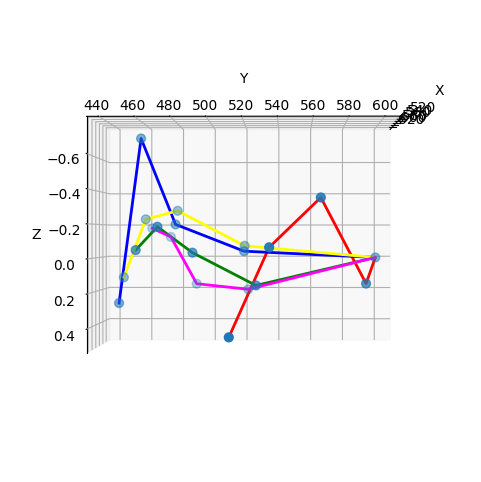

In [52]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display

def hand_visualization(x, y, z):
    fig = plt.figure(figsize=(15,6))
    ax = plt.axes(projection='3d')
    
    # 3D로 시각화합니다.
    ax.scatter3D(x[:21], y[:21], z[:21], s=40, c='#1f77b4')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Thumb
    ax.plot([x[0], x[1], x[2], x[3], x[4]], [y[0], y[1], y[2], y[3], y[4]], [z[0], z[1], z[2], z[3], z[4]], linewidth=2, color='red')
    # Index finger
    ax.plot([x[0], x[5], x[6], x[7], x[8]], [y[0], y[5], y[6], y[7], y[8]], [z[0], z[5], z[6], z[7], z[8]], linewidth=2, color='green')
    # Middle finger
    ax.plot([x[0], x[9], x[10], x[11], x[12]], [y[0], y[9], y[10], y[11], y[12]], [z[0], z[9], z[10], z[11], z[12]], linewidth=2, color='blue')
    # Ring finger
    ax.plot([x[0], x[13], x[14], x[15], x[16]], [y[0], y[13], y[14], y[15], y[16]], [z[0], z[13], z[14], z[15], z[16]], linewidth=2, color='yellow')
    # Pinky
    ax.plot([x[0], x[17], x[18], x[19], x[20]], [y[0], y[17], y[18], y[19], y[20]], [z[0], z[17], z[18], z[19], z[20]], linewidth=2, color='magenta')
    
    #ax.view_init(elev=180, azim=100)    # 각도 지정
    plt.savefig(f'scatter_1_new.png')
    # 360도 회전하는 걸 반복하면서 그래프를 출력
    def animate(i):
        ax.view_init(elev=180, azim=i)
        return ax

    ani = animation.FuncAnimation(fig, animate, frames=360, interval=20)
    ani.save(f'mpl3d_scatter_predict.gif', fps=30)

# x_coords, y_coords, z_coords를 이용하여 그래프 그리기
hand_visualization(x_coords, y_coords, z_coords)

In [57]:
# ground truth (맨 마지막 행만 read)
# 1.csv 파일 경로 설정
csv_file = '1.csv'

# 라벨 값을 저장할 리스트 초기화
label_values = []

# 1.csv 파일에서 라벨 값 로드
with open(csv_file, mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        label_values = [float(value) for value in row]
        
def coord_division(coord_list):
    x_list = []
    y_list = []
    z_list = []
    
    for i in range(len(coord_list)): # len(coord_list) : 126개
        if i % 3 == 0:
            x_list.append(coord_list[i])
        elif i % 3 == 1:
            y_list.append(coord_list[i])
        else:
            z_list.append(coord_list[i])
    
    # 각 리스트를 NumPy 배열로 변환하여 반환
    x_array = np.array(x_list)
    y_array = np.array(y_list)
    z_array = np.array(z_list)
    
    return x_array, y_array, z_array

# 1.csv 파일에서 로드한 라벨 값을 coord_division 함수에 전달하여 좌표를 나눠서 저장
#label_values
x_coords, y_coords, z_coords = coord_division(label_values)

MovieWriter ffmpeg unavailable; using Pillow instead.


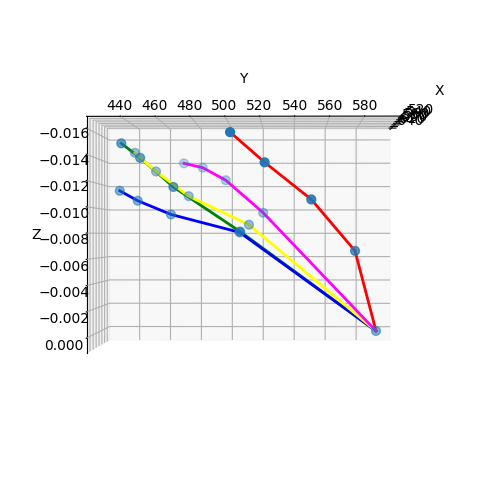

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display

def hand_visualization(x, y, z):
    fig = plt.figure(figsize=(15,6))
    ax = plt.axes(projection='3d')
    
    # 3D로 시각화합니다.
    ax.scatter3D(x[:21], y[:21], z[:21], s=40, c='#1f77b4')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Thumb
    ax.plot([x[0], x[1], x[2], x[3], x[4]], [y[0], y[1], y[2], y[3], y[4]], [z[0], z[1], z[2], z[3], z[4]], linewidth=2, color='red')
    # Index finger
    ax.plot([x[0], x[5], x[6], x[7], x[8]], [y[0], y[5], y[6], y[7], y[8]], [z[0], z[5], z[6], z[7], z[8]], linewidth=2, color='green')
    # Middle finger
    ax.plot([x[0], x[9], x[10], x[11], x[12]], [y[0], y[9], y[10], y[11], y[12]], [z[0], z[9], z[10], z[11], z[12]], linewidth=2, color='blue')
    # Ring finger
    ax.plot([x[0], x[13], x[14], x[15], x[16]], [y[0], y[13], y[14], y[15], y[16]], [z[0], z[13], z[14], z[15], z[16]], linewidth=2, color='yellow')
    # Pinky
    ax.plot([x[0], x[17], x[18], x[19], x[20]], [y[0], y[17], y[18], y[19], y[20]], [z[0], z[17], z[18], z[19], z[20]], linewidth=2, color='magenta')
    
    #ax.view_init(elev=180, azim=100)    # 각도 지정
    plt.savefig(f'scatter_2_new.png')
    # 360도 회전하는 걸 반복하면서 그래프를 출력
    def animate(i):
        ax.view_init(elev=180, azim=i)
        return ax

    ani = animation.FuncAnimation(fig, animate, frames=360, interval=20)
    ani.save(f'mpl3d_scatter_groundtruth.gif', fps=30)

# x_coords, y_coords, z_coords를 이용하여 그래프 그리기
hand_visualization(x_coords, y_coords, z_coords)